In [16]:
import numpy as np
import pandas as pd
import talib as ta

In [17]:
# 1.读取行情数据
z = pd.read_csv('510050.SH_15.csv',index_col=0)
z

,open,high,low,close,volume
etime,,,,,
2005/2/23 9:45,0.6477,0.6484,0.6367,0.6433,292237380
2005/2/23 10:00,0.6426,0.6462,0.6426,0.6448,149050869
2005/2/23 10:15,0.6455,0.6455,0.6433,0.6440,95944065
2005/2/23 10:30,0.6440,0.6455,0.6426,0.6440,89684501
2005/2/23 10:45,0.6440,0.6470,0.6440,0.6462,63594170
...,...,...,...,...,...
2022/11/29 14:00,2.6011,2.6060,2.5991,2.6041,25373019
2022/11/29 14:15,2.6031,2.6080,2.6011,2.6021,37810520
2022/11/29 14:30,2.6021,2.6060,2.6021,2.6041,26428800


In [18]:
# 2.构建一个因子
# 注意这里输入的是z.close是一个pd.Series，所以输出也是pd.Series
up,mid,low = ta.BBANDS(z.close,100)  # bollinger布林带因子
# 计算现价在通道中的位置
x = (up-z.close)/(up-low)

In [19]:
x

etime
2005/2/23 9:45           NaN
2005/2/23 10:00          NaN
2005/2/23 10:15          NaN
2005/2/23 10:30          NaN
2005/2/23 10:45          NaN
                      ...   
2022/11/29 14:00   -0.106059
2022/11/29 14:15   -0.068300
2022/11/29 14:30   -0.063875
2022/11/29 14:45   -0.066009
2022/11/29 15:00   -0.075202
Length: 69152, dtype: float64

<Axes: >

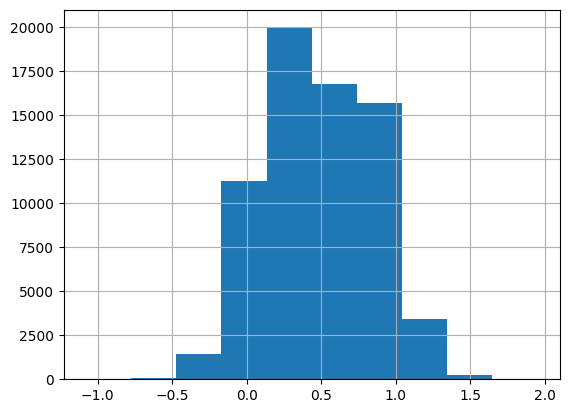

In [20]:
# 查看标准化之前因子的分布状况
x.hist()

In [21]:
# 3.对因子进行滚动标准化。为什么要对因子进行滚动标准化？
import main
norm_x = main.norm(x)

<Axes: >

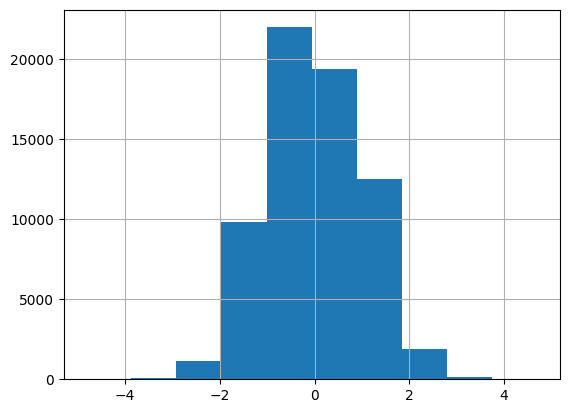

In [22]:
norm_x.hist()

In [23]:
# 4.对因子进行clip截断处理。为什么要对因子进行clip截断处理？
norm_x = norm_x.clip(-3,3)

<Axes: >

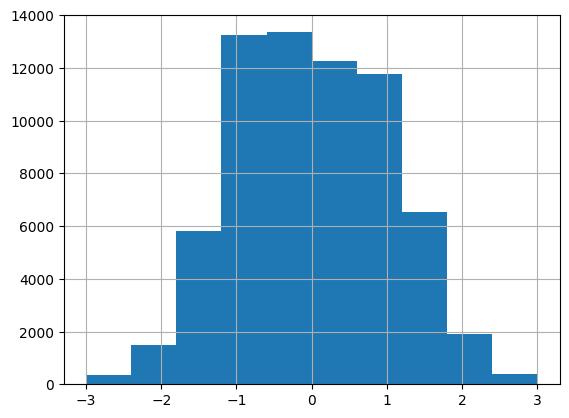

In [24]:
# 4.查看因子的分布状况
norm_x.hist()

count    69151.000000
mean         0.000028
std          0.003812
min         -0.063417
25%         -0.001566
50%          0.000000
75%          0.001546
max          0.100292
Name: close, dtype: float64


<Axes: >

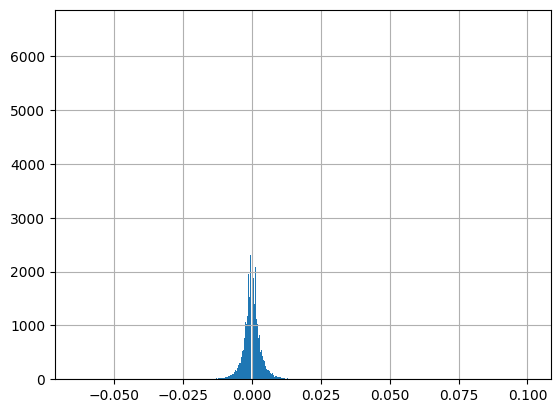

In [25]:
# 5.查看收益率的分布情况
ret = z.close.shift(-1)/z.close - 1
print(ret.describe())
ret.hist(bins=1000)

In [26]:
# 我们来总结一下因子净值的计算公式
# 1+（仓位的大小*收益率-仓位变动的绝对值*磨损成本(滑点、手续费等)）.cumsum()

In [27]:
# 6.计算净值
def cal_net_values(pos:np.array,ret:np.array) -> np.array:
    '''计算净值序列
    pos: 仓位
    ret:未来1个周期的收益率'''
    fee = 0  # 仓位每次变动的磨损
    position_changes = np.hstack((pos[0],np.diff(pos)))
    net_values = 1+(pos*ret-np.abs(position_changes*fee)).cumsum() 
    return net_values  # 返回净值序列

In [34]:
pos = np.array(norm_x)
ret = np.array(ret)
net_value = cal_net_values(norm_x,ret)

C:\Users\iisdm\AppData\Local\Temp\ipykernel_22012\4073625045.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_changes = np.hstack((pos[0],np.diff(pos)))


<Axes: xlabel='etime'>

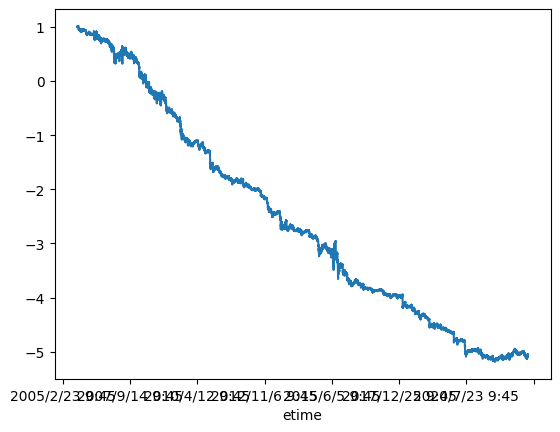

In [35]:
net_value.plot()

<Axes: >

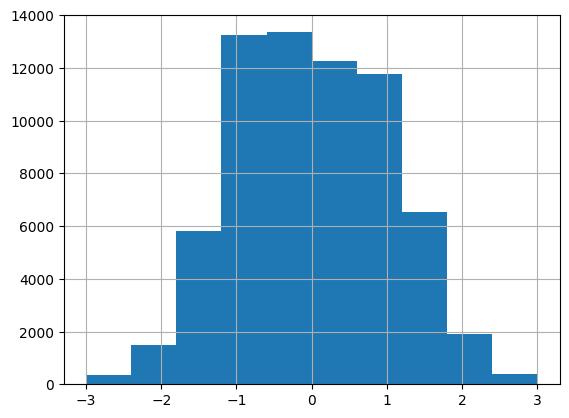

In [ ]:
pd.Series(pos).hist()  # 查看仓位的分布

<Axes: >

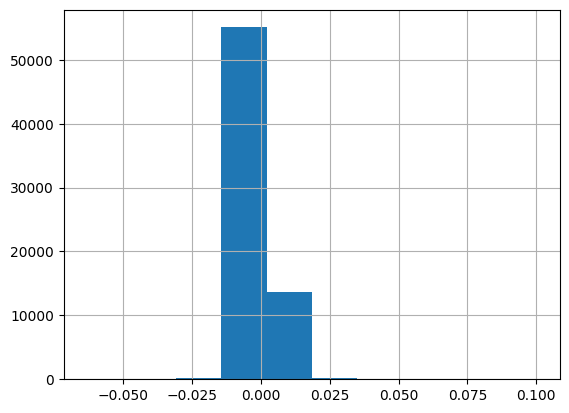

In [ ]:
pd.Series(ret).hist()  # 查看收益率的分布

In [ ]:
# 计算夏普比率
def cal_sharp(ret:pd.Series,pos:pd.Series) -> float:
    '''计算夏普比率,risk free rate为无风险年化收益率,trading days是1年总的交易日
    -------------------------------------------------------------------------
    Params:
    ret: 未来一个周期的收益率
    pos: 仓位，也就是因子值
    -------------------------------------------------------------------------'''
    rf = 0.03  # 无风险利率
    N = 252  # 一年总的交易日
    # 注意！在计算夏普比率的时候，日频（就是每天去算收益率）的sharpe计算方式应该是
    # sharpe = (factor_ret.mean()*np.sqrt(N)-rf/(N))/factor_ret.std()
    # 而这里因为我们是15分钟调仓，所以每个收益率是每15分钟的收益率，我们要用N*16
    # 16是一天有16个15分钟（一小时有4个15分钟，一天一共交易4个小时）
    factor_ret = ret*pos  # 计算因子的收益率
    sharpe = (factor_ret.mean()*np.sqrt(N*16)-rf/(N*16))/factor_ret.std()
    return sharpe

In [42]:
cal_sharp(pd.Series(ret),pd.Series(pos))

np.float64(-1.3153327092039682)